In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
print('imported libs ..')

/home/dlgpu-aus/anaconda3/envs/nlp/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


imported libs ..


In [2]:
train = pd.read_csv('tweet-sentiment-extraction-data/train.csv')
test = pd.read_csv('tweet-sentiment-extraction-data/test.csv')

In [3]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


We have one null object, so we can drop that row

In [5]:
train.dropna(inplace=True)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [7]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,a0d8a9b547,"alkaline trio was sweet, saves the day sucked....",good,neutral
freq,1,1,199,11117


In [8]:
train.text[1]

' Sooo SAD I will miss you here in San Diego!!!'

In [9]:
train.selected_text[1]

'Sooo SAD'

In [10]:
train.sentiment[1]

'negative'

In [11]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [13]:
print(train.shape)
print(test.shape)

(27480, 4)
(3534, 3)


In [14]:
print("There are {} percentage of test data proportion compared to train data".format(round(test.shape[0]/train.shape[0]*100,2)))

There are 12.86 percentage of test data proportion compared to train data


In [15]:
train.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

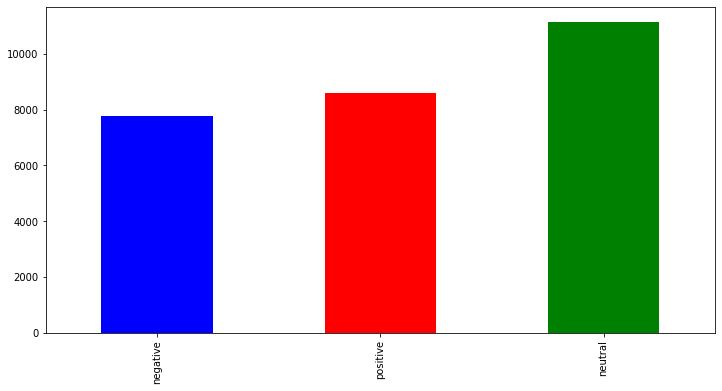

In [16]:
plt.figure(figsize=(12,6))
train.sentiment.value_counts().sort_values().plot(kind = 'bar', color = ['b', 'r', 'g'] )

### Data Features

Some observations of the data:
* selected_text is subset of text
* selected_text is a segment of a single sentence in the text. It does not have parts of multiple sentences

We will try to obtain more insights on selected_text & text and their relations for each sentiment

### Preprocess on selected_text variable

Let us derive similarities between selected_text and the actual text and check their probable influence on the classifier

In [17]:
from nltk.metrics.distance import jaccard_distance, jaro_winkler_similarity

In [18]:
similarity_score = []
for index, row in train.iterrows():
    score = jaro_winkler_similarity(row['selected_text'], row['text'])
    similarity_score.append(score)

In [19]:
train['similarity_score'] = similarity_score

In [20]:
grouped = train.groupby('sentiment', as_index=False)['similarity_score'].mean()

In [21]:
grouped.head()

,sentiment,similarity_score
0,negative,0.657112
1,neutral,0.928392
2,positive,0.650928


We can observe that tweets with neutral sentiments have very similar selected_text and  text ie; 92.8% similar. In most neutral tweets, the entire text is selected for the sentiment extraction

In [22]:
train['num_words_sel_text'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['num_words_text'] = train['text'].apply(lambda x:len(str(x).split()))
train['diff_text_sel_text'] = train['num_words_text'] - train['num_words_sel_text'] 

In [23]:
train.head()

,textID,text,selected_text,sentiment,similarity_score,num_words_sel_text,num_words_text,diff_text_sel_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0.847884,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.682971,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.661818,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.592306,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.621880,3,14,11


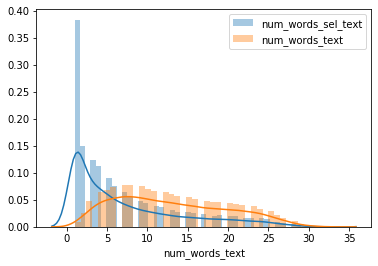

In [24]:
# plt.figure() 
sns.distplot(train['num_words_sel_text'], label='num_words_sel_text')
sns.distplot(train['num_words_text'], label='num_words_text')
plt.legend();

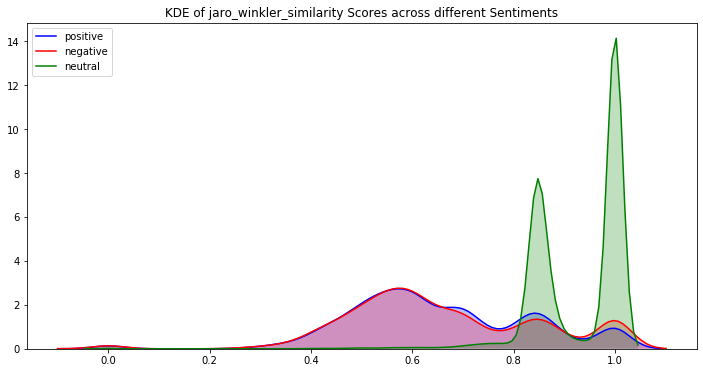

In [25]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['similarity_score'], shade=True, color="b").set_title('KDE of jaro_winkler_similarity Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['similarity_score'], shade=True, color="r")
p3=sns.kdeplot(train[train['sentiment']=='neutral']['similarity_score'], shade=True, color="g")
# plt.legend(labels=['positive','negative'])
plt.legend(labels=['positive','negative','neutral'])

Again, we can observe from the graph that the neutral tweets have higher similarity

In [26]:
train['target'] = train['selected_text'].str.lower()

In [27]:
def get_url_from_string(text):
    regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    url = re.findall(regex,text)       
    return "".join(url) 

In [28]:
train['target_url']=train['target'].apply(lambda x: get_url_from_string(x))

In [29]:
train.head()

,textID,text,selected_text,sentiment,similarity_score,num_words_sel_text,num_words_text,diff_text_sel_text,target,target_url
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0.847884,7,7,0,"i`d have responded, if i were going",
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.682971,2,10,8,sooo sad,
2,088c60f138,my boss is bullying me...,bullying me,negative,0.661818,2,5,3,bullying me,
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.592306,3,5,2,leave me alone,
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.621880,3,14,11,"sons of ****,",


Make a separate dataframe to see all the selected texts which have urls and their distributions over sentiments

In [30]:
df=pd.DataFrame(train.loc[train['target_url']!=""]['sentiment'].value_counts()).reset_index()
df.rename(columns={"index": "sentiment", "sentiment": "url_count"})

,sentiment,url_count
0,neutral,345
1,positive,3
2,negative,3


We can observe that most of the selected texts that have urls are classified as neutral sentiment. This may create a biased classifier to classify ant selcted text having a url as neutral sentiment.

### Effect of punctuations

In [31]:
def find_punct(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)

In [32]:
train['target_punct']=train['target'].apply(lambda x:find_punct(x))
train['target_punct_len']=train['target'].apply(lambda x:len(find_punct(x)))

In [33]:
train.head()

,textID,text,selected_text,sentiment,similarity_score,num_words_sel_text,num_words_text,diff_text_sel_text,target,target_url,target_punct,target_punct_len
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0.847884,7,7,0,"i`d have responded, if i were going",,"[`, ,]",2
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.682971,2,10,8,sooo sad,,[],0
2,088c60f138,my boss is bullying me...,bullying me,negative,0.661818,2,5,3,bullying me,,[],0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.592306,3,5,2,leave me alone,,[],0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.621880,3,14,11,"sons of ****,",,"[*, *, *, *, ,]",5


In [34]:
punc_df=pd.DataFrame(train,columns=['target_punct','sentiment'])
punc_df=punc_df[punc_df['target_punct'].map(lambda d: len(d)) > 0]
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html
punc_df=punc_df.explode('target_punct')
punc_df.head()

,target_punct,sentiment
0,`,neutral
0,",",neutral
4,*,negative
4,*,negative
4,*,negative


In [35]:
punc_df.groupby('sentiment').target_punct.value_counts()

sentiment  target_punct
negative   .               3118
           *               1343
           !               1282
           `               1253
           ,                591
                           ... 
positive   ]                  2
           ^                  2
           $                  1
           [                  1
           |                  1
Name: target_punct, Length: 84, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3992cea10>,
      dtype=object)

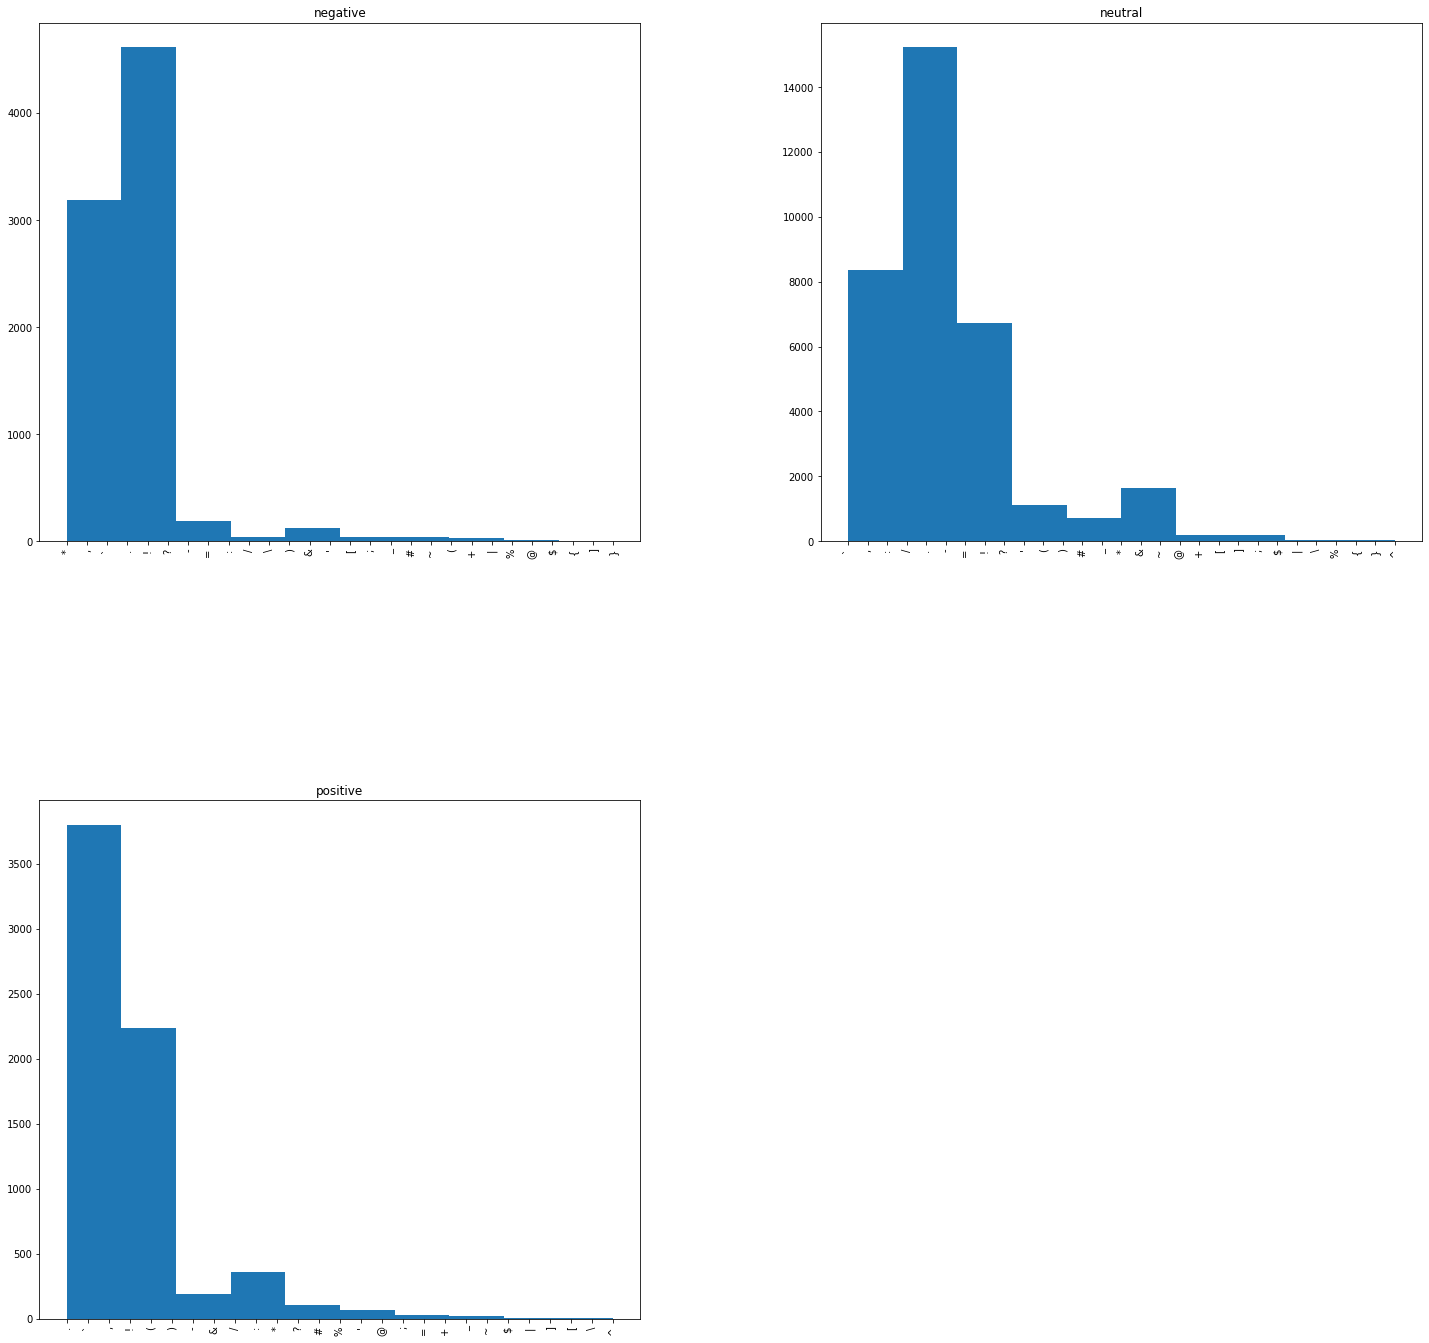

In [36]:
punc_df['target_punct'].hist(by = punc_df['sentiment'], figsize=(24,24))

In [37]:
# punc_df.reset_index()

### Common Words used

In [38]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.append('i')
def remove_stopword(x):
    return [y for y in x if y not in stopword_list]

In [39]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).lower().split())
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

    

,Common_words,count
0,i`m,1195
1,good,1075
2,love,865
3,happy,801
4,day,784
5,get,765
6,like,753
7,go,648
8,it`s,627
9,going,569


In [40]:

train['temp_list_text'] = train['text'].apply(lambda x:str(x).lower().split())
train['temp_list_text'] = train['temp_list_text'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in train['temp_list_text'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i`m,2173
1,day,1481
2,get,1415
3,good,1325
4,like,1303
5,it`s,1174
6,go,1162
7,-,1147
8,got,1069
9,going,1062


### Most Common Words for each sentiment

In [41]:
train.head()

,textID,text,selected_text,sentiment,similarity_score,num_words_sel_text,num_words_text,diff_text_sel_text,target,target_url,target_punct,target_punct_len,temp_list,temp_list_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0.847884,7,7,0,"i`d have responded, if i were going",,"[`, ,]",2,"[i`d, responded,, going]","[i`d, responded,, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.682971,2,10,8,sooo sad,,[],0,"[sooo, sad]","[sooo, sad, miss, san, diego!!!]"
2,088c60f138,my boss is bullying me...,bullying me,negative,0.661818,2,5,3,bullying me,,[],0,[bullying],"[boss, bullying, me...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.592306,3,5,2,leave me alone,,[],0,"[leave, alone]","[interview!, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.621880,3,14,11,"sons of ****,",,"[*, *, *, *, ,]",5,"[sons, ****,]","[sons, ****,, couldn`t, put, releases, already..."


## Most Common positive words

In [42]:
pos_df = train.loc[train['sentiment'] == 'positive']
pos_df.head()

,textID,text,selected_text,sentiment,similarity_score,num_words_sel_text,num_words_text,diff_text_sel_text,target,target_url,target_punct,target_punct_len,temp_list,temp_list_text
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.571181,1,14,13,fun,,[],0,[fun],"[2am, feedings, baby, fun, smiles, coos]"
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,0.659075,5,10,5,wow... u just became cooler.,,"[., ., ., .]",4,"[wow..., u, became, cooler.]","[journey!?, wow..., u, became, cooler., hehe....."
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive,0.523810,1,11,10,like,,[],0,[like],"[really, really, like, song, love, story, tayl..."
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive,0.585185,1,24,23,interesting.,,[.],1,[interesting.],"[playing, ghost, online, really, interesting.,..."
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,1.000000,11,11,0,"the free fillin` app on my ipod is fun, im add...",,"[`, ,]",2,"[free, fillin`, app, ipod, fun,, im, addicted]","[free, fillin`, app, ipod, fun,, im, addicted]"


In [43]:
top = Counter([item for sublist in pos_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,good,711
1,happy,701
2,love,671
3,thanks,341
4,day,321
5,great,307
6,hope,236
7,nice,222
8,fun,211
9,thank,174


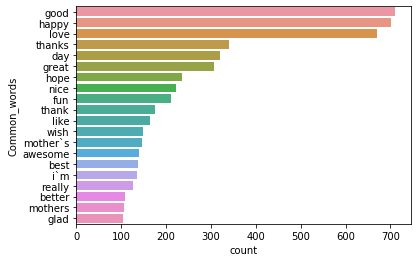

In [44]:
sns.barplot(x="count", y="Common_words", data=temp)

## Most Common negative words

In [45]:
neg_df = train.loc[train['sentiment'] == 'negative']
neg_df.head()

,textID,text,selected_text,sentiment,similarity_score,num_words_sel_text,num_words_text,diff_text_sel_text,target,target_url,target_punct,target_punct_len,temp_list,temp_list_text
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.682971,2,10,8,sooo sad,,[],0,"[sooo, sad]","[sooo, sad, miss, san, diego!!!]"
2,088c60f138,my boss is bullying me...,bullying me,negative,0.661818,2,5,3,bullying me,,[],0,[bullying],"[boss, bullying, me...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.592306,3,5,2,leave me alone,,[],0,"[leave, alone]","[interview!, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.621880,3,14,11,"sons of ****,",,"[*, *, *, *, ,]",5,"[sons, ****,]","[sons, ****,, couldn`t, put, releases, already..."
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,0.335859,1,8,7,dangerously,,[],0,[dangerously],"[sharpie, running, dangerously, low, ink]"


In [46]:
top = Counter([item for sublist in neg_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,miss,358
1,i`m,320
2,sad,257
3,sorry,237
4,****,231
5,hate,229
6,bad,202
7,don`t,163
8,like,159
9,feel,157


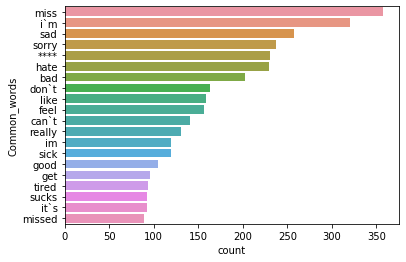

In [47]:
sns.barplot(x="count", y="Common_words", data=temp)

## Most Common neutral words

In [48]:
neutral_df = train.loc[train['sentiment'] == 'neutral']
neutral_df.head()

,textID,text,selected_text,sentiment,similarity_score,num_words_sel_text,num_words_text,diff_text_sel_text,target,target_url,target_punct,target_punct_len,temp_list,temp_list_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0.847884,7,7,0,"i`d have responded, if i were going",,"[`, ,]",2,"[i`d, responded,, going]","[i`d, responded,, going]"
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,12,12,0,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf,"[:, /, /, ., ., /, -]",7,"[http://www.dothebouncy.com/smf, -, shameless,...","[http://www.dothebouncy.com/smf, -, shameless,..."
7,50e14c0bb8,Soooo high,Soooo high,neutral,1.000000,2,2,0,soooo high,,[],0,"[soooo, high]","[soooo, high]"
8,e050245fbd,Both of you,Both of you,neutral,0.851010,3,3,0,both of you,,[],0,[],[]
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,0.839652,23,23,0,"as much as i love to be hopeful, i reckon the ...",,"[,, =, `]",3,"[much, love, hopeful,, reckon, chances, minima...","[much, love, hopeful,, reckon, chances, minima..."


In [49]:
top = Counter([item for sublist in neutral_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i`m,740
1,get,606
2,go,525
3,going,451
4,it`s,451
5,got,441
6,like,431
7,-,403
8,day,378
9,work,371


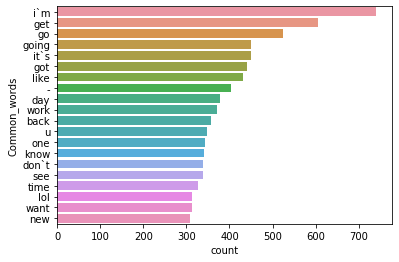

In [50]:
sns.barplot(x="count", y="Common_words", data=temp)

### Word Clouds

### For Neutral Tweets: "Text"

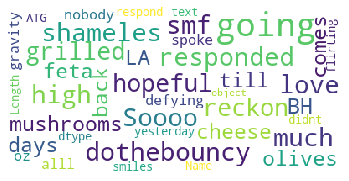

In [52]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(neutral_df['text']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


### For Neutral Tweets: "selected_text"

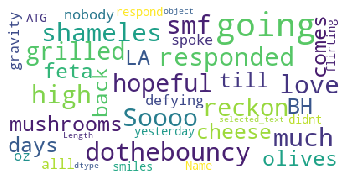

In [53]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(neutral_df['selected_text']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### For Positive Tweets: "text"

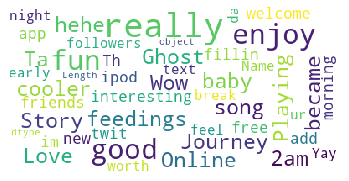

In [55]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(pos_df['text']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### For Positive Tweets: "selected_text"

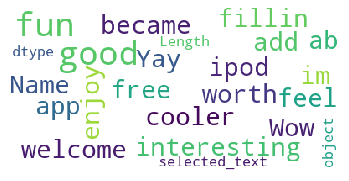

In [54]:

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(pos_df['selected_text']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### For Negative Tweets: "text"

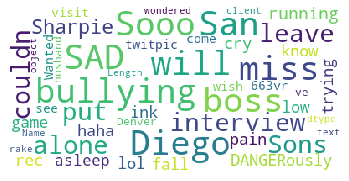

In [56]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(neg_df['text']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### For Negative Tweets: "selected_text"

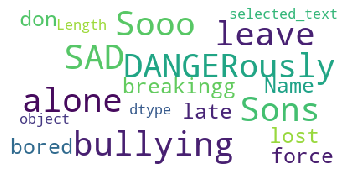

In [57]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(neg_df['selected_text']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### N-grams Analysis

Even from the word clouds generated, we can observe that the words in the both **text** and **selected_text** clouds for neutral tweets are same.

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n),stop_words=stopword_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]
    


### Bigrams for  text

Text(0.5, 1.0, 'Neutral')

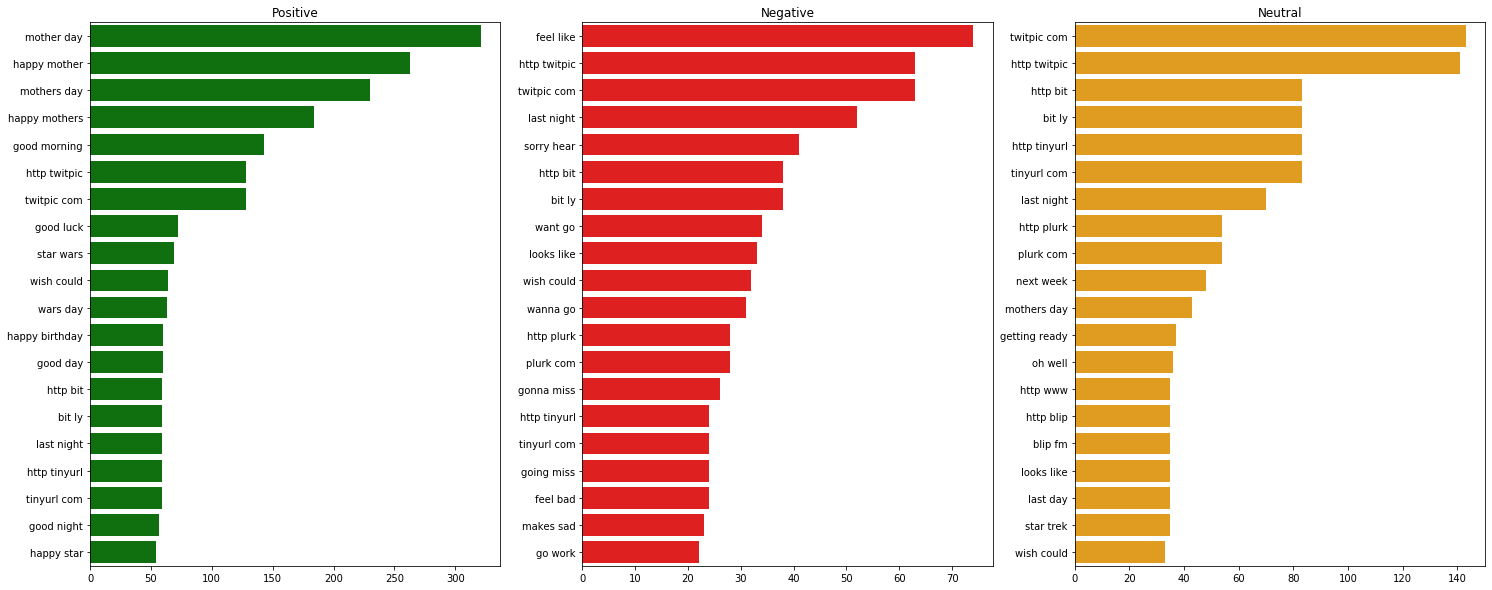

In [70]:
fig,ax=plt.subplots(1,3,figsize=(25,10))
# print(len(ax))
top_n_bigrams_pos_text = get_top_ngram(pos_df.text,2)[:20]
x,y=map(list,zip(*top_n_bigrams_pos_text))
sns.barplot(x=y,y=x,ax=ax[0],color="green")
ax[0].set_title("Positive")

top_n_bigrams_neg_text = get_top_ngram(neg_df.text,2)[:20]
x,y=map(list,zip(*top_n_bigrams_neg_text))
sns.barplot(x=y,y=x,ax=ax[1],color="red")
ax[1].set_title("Negative")

top_n_bigrams_neutral_text = get_top_ngram(neutral_df.text,2)[:20]
x,y=map(list,zip(*top_n_bigrams_neutral_text))
sns.barplot(x=y,y=x,ax=ax[2],color="orange")
ax[2].set_title("Neutral")

### Bigrams for  selected_text

Text(0.5, 1.0, 'Neutral')

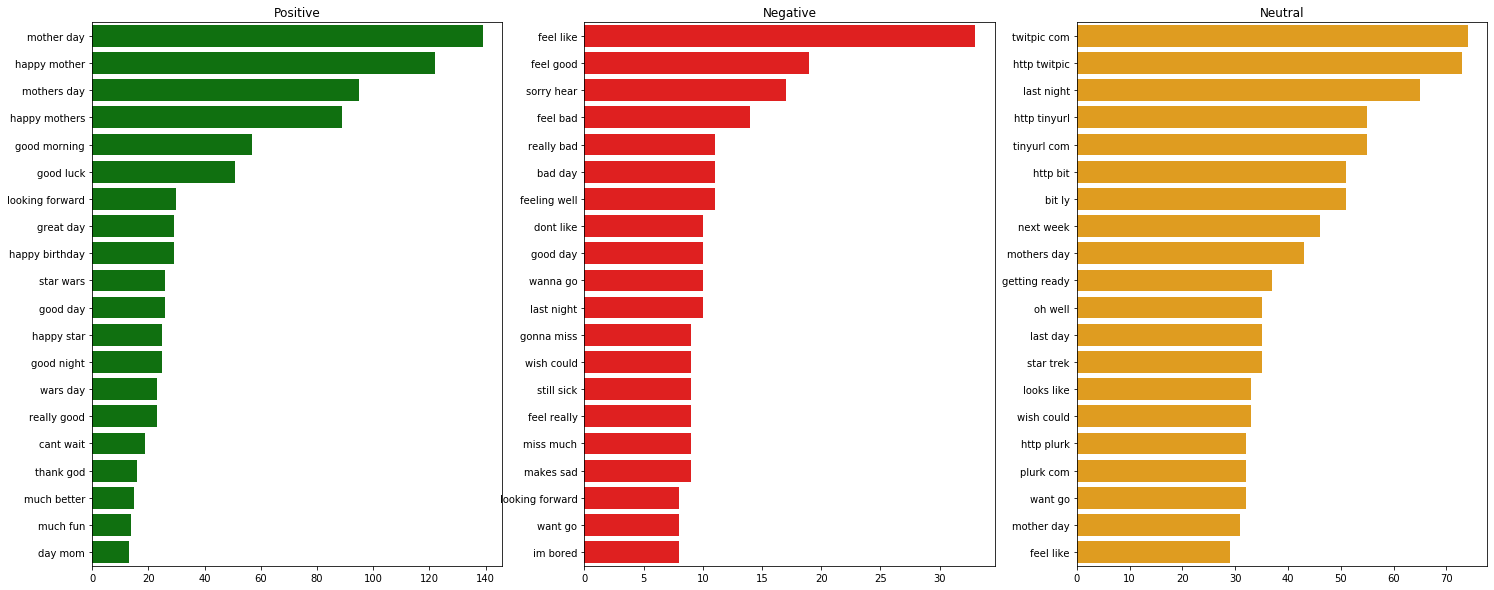

In [71]:
fig,ax=plt.subplots(1,3,figsize=(25,10))
# print(len(ax))
top_n_bigrams_pos_text = get_top_ngram(pos_df.selected_text,2)[:20]
x,y=map(list,zip(*top_n_bigrams_pos_text))
sns.barplot(x=y,y=x,ax=ax[0],color="green")
ax[0].set_title("Positive")

top_n_bigrams_neg_text = get_top_ngram(neg_df.selected_text,2)[:20]
x,y=map(list,zip(*top_n_bigrams_neg_text))
sns.barplot(x=y,y=x,ax=ax[1],color="red")
ax[1].set_title("Negative")

top_n_bigrams_neutral_text = get_top_ngram(neutral_df.selected_text,2)[:20]
x,y=map(list,zip(*top_n_bigrams_neutral_text))
sns.barplot(x=y,y=x,ax=ax[2],color="orange")
ax[2].set_title("Neutral")

### Trigrams for text

Text(0.5, 1.0, 'Neutral')

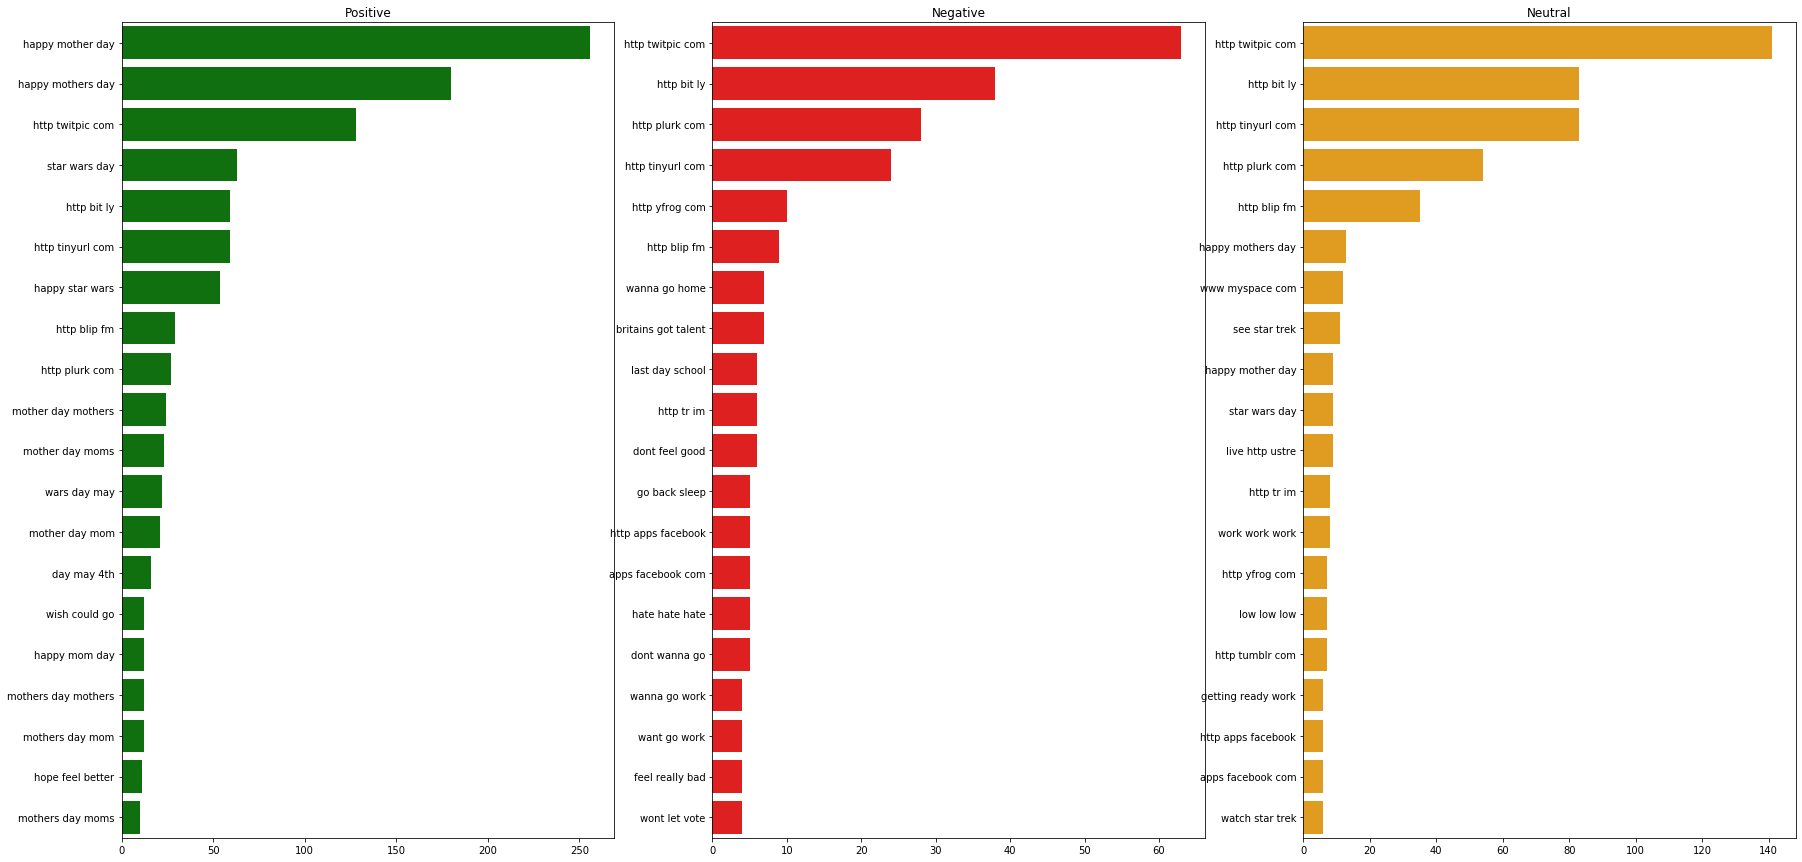

In [74]:
fig,ax=plt.subplots(1,3,figsize=(30,15))
# print(len(ax))
top_n_bigrams_pos_text = get_top_ngram(pos_df.text,3)[:20]
x,y=map(list,zip(*top_n_bigrams_pos_text))
sns.barplot(x=y,y=x,ax=ax[0],color="green")
ax[0].set_title("Positive")

top_n_bigrams_neg_text = get_top_ngram(neg_df.text,3)[:20]
x,y=map(list,zip(*top_n_bigrams_neg_text))
sns.barplot(x=y,y=x,ax=ax[1],color="red")
ax[1].set_title("Negative")

top_n_bigrams_neutral_text = get_top_ngram(neutral_df.text,3)[:20]
x,y=map(list,zip(*top_n_bigrams_neutral_text))
sns.barplot(x=y,y=x,ax=ax[2],color="orange")
ax[2].set_title("Neutral")

### Trigrams for selected_text

Text(0.5, 1.0, 'Neutral')

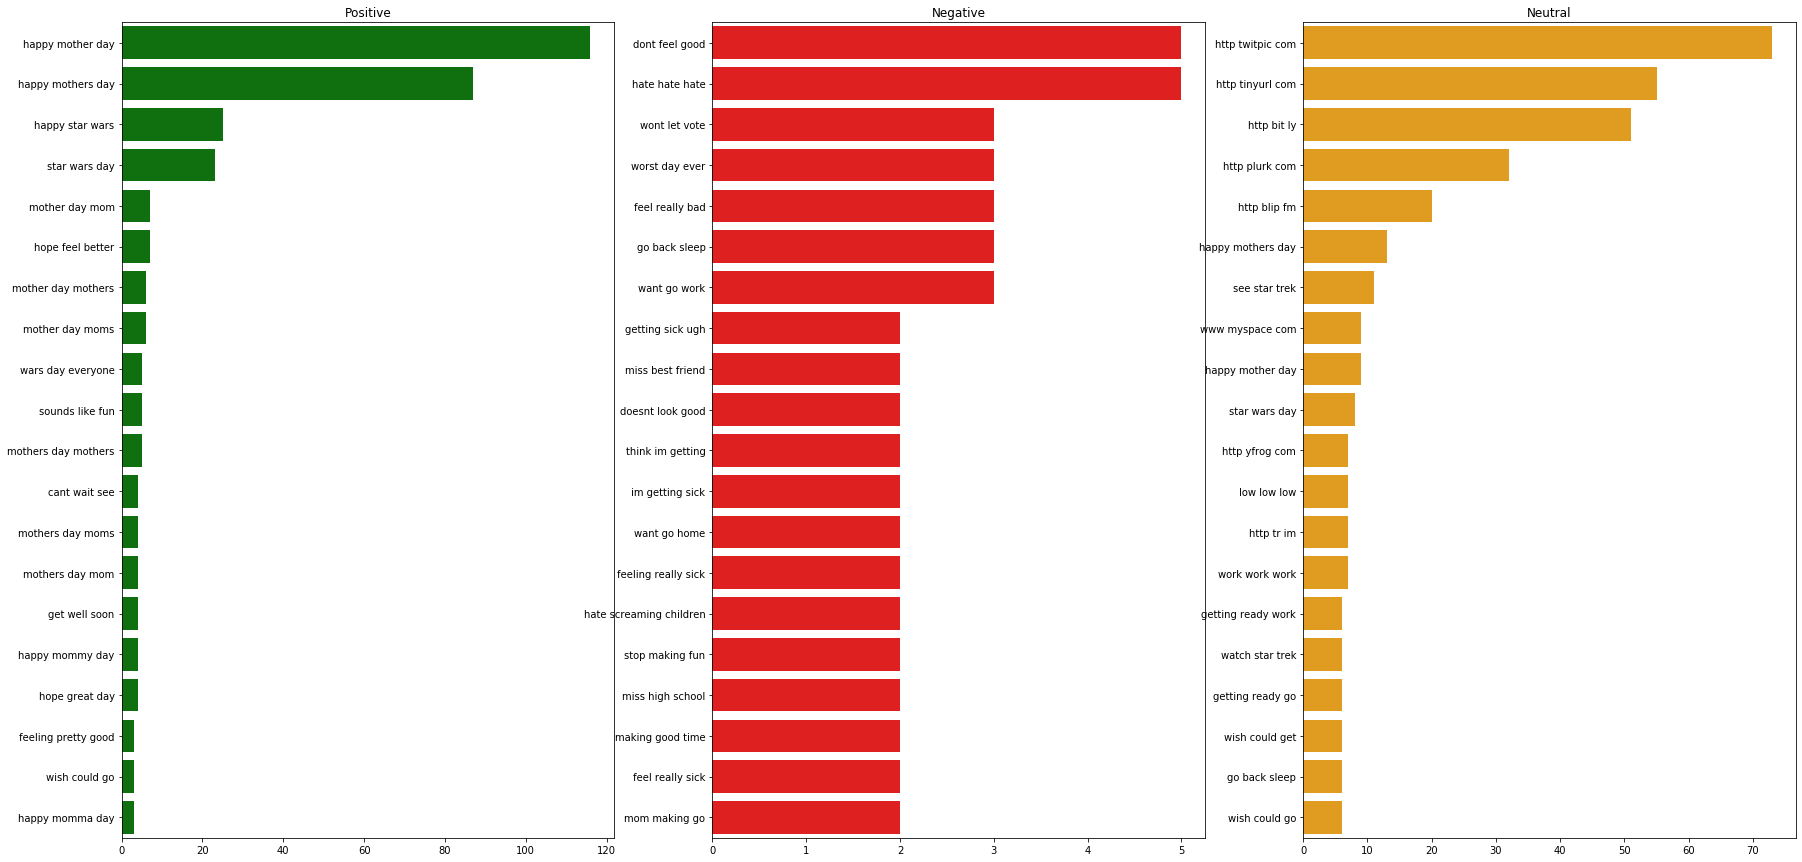

In [75]:
fig,ax=plt.subplots(1,3,figsize=(30,15))
# print(len(ax))
top_n_bigrams_pos_text = get_top_ngram(pos_df.selected_text,3)[:20]
x,y=map(list,zip(*top_n_bigrams_pos_text))
sns.barplot(x=y,y=x,ax=ax[0],color="green")
ax[0].set_title("Positive")

top_n_bigrams_neg_text = get_top_ngram(neg_df.selected_text,3)[:20]
x,y=map(list,zip(*top_n_bigrams_neg_text))
sns.barplot(x=y,y=x,ax=ax[1],color="red")
ax[1].set_title("Negative")

top_n_bigrams_neutral_text = get_top_ngram(neutral_df.selected_text,3)[:20]
x,y=map(list,zip(*top_n_bigrams_neutral_text))
sns.barplot(x=y,y=x,ax=ax[2],color="orange")
ax[2].set_title("Neutral")